In [2]:
# Prepare Dataset

In [268]:
# Load package
import os
import time
import re
from glob import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from PIL import Image

print("Tensorflow: v{}".format(tf.__version__))
%matplotlib inline

Tensorflow: v2.8.0


In [301]:
# Load
#image dataset labels

import pandas as pd
# df = pd.read_csv('/Users/seunghee/Downloads/CXR8/test.csv', names=['a', 'b', 'c'], header=None)
#df.rename(columns = {'a':'A', 'b':'B', 'c':'C'}, inplace = True) 
# df.to_csv('file.csv')
base_dir =  '/Users/seunghee/Desktop/hackathon dataset'

df = pd.read_csv(f'{base_dir}/Dataset_Chest_X_Ray_Sample.csv',sep=';')
df

,Image_Index,Finding_Labels,Follow_up,Patient_ID,Patient_Age,Patient_Gender,View_Position,Original_Image_Width,Original_Image_Height,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000005_000.png,No Finding,0,5,69,F,PA,2048,2500,"0,168","0,168"
1,00000005_001.png,No Finding,1,5,69,F,AP,2500,2048,"0,168","0,168"
2,00000005_003.png,No Finding,3,5,69,F,PA,2992,2991,"0,143","0,143"
3,00000009_000.png,Emphysema,0,9,72,M,PA,2992,2991,"0,143","0,143"
4,00000011_001.png,No Finding,1,11,74,M,PA,2500,2048,"0,168","0,168"
...,...,...,...,...,...,...,...,...,...,...,...
10011,00030780_000.png,Atelectasis,0,30780,66,M,PA,2021,2021,"0,194311","0,194311"
10012,00030782_000.png,No Finding,0,30782,40,M,AP,3056,2544,"0,139","0,139"
10013,00030787_000.png,No Finding,0,30787,33,M,PA,2021,2021,"0,194311","0,194311"
10014,00030791_000.png,No Finding,0,30791,49,M,PA,2021,2021,"0,194311","0,194311"


In [331]:
# Make diseases labels
labels = df['Finding_Labels'].drop_duplicates()
disease_labels = {}
for idx,label in enumerate(labels):
    disease_labels[label]= idx
disease_labels

{'No Finding': 0,
 'Emphysema': 1,
 'Pleural_Thickening': 2,
 'Cardiomegaly': 3,
 'Infiltration': 4,
 'Pneumothorax': 5,
 'Atelectasis': 6,
 'Effusion': 7,
 'Nodule': 8,
 'Fibrosis': 9,
 'Consolidation': 10,
 'Mass': 11,
 'Edema': 12,
 'Pneumonia': 13,
 'Hernia': 14}

In [332]:
def resize(input_image, size):
    return tf.image.resize(input_image, size)

def load(f, label):
    # load the file into tensor
    image = tf.io.read_file(f)
    # Decode it to JPEG format
    image = tf.image.decode_jpeg(image)
#     # resize the image 
#     image = resize(image, [176, 176])
    # Convert it to tf.float32
    image = tf.cast(image, tf.float32)
    
    return image, label

In [333]:
def random_crop(input_image):
    return tf.image.random_crop(input_image, size=[150, 150, 1])

def random_rotation(input_image):
    angles = np.random.randint(0, 3, 1)
    return tf.image.rot90(input_image, k=angles[0])

# API crops from the center point based on the fraction
def central_crop(input_image):
    image = resize(input_image, [176, 176])
    return tf.image.central_crop(image, central_fraction=0.84)

# merge it in one API, called random_jitter. And can add another image transformation function, like random_flip_left_right
def random_jitter(input_image):
    # Resize it to 176 x 176 x 3
    image = resize(input_image, [176, 176])
    # Randomly Crop to 150 x 150 x 3
    image = random_crop(image)
    # Randomly rotation
    image = random_rotation(image)
    # Randomly mirroring
    image = tf.image.random_flip_left_right(image)
    return image


In [334]:
'''
Normalization is one of method for rescaling. 
There are several techniques for normalization. But in this API, our normalize function will be
convert the value range from [0, 255] to [0, 2]
move the value range from [0, 2] to [-1, 1]
After that, whole value in image will be in range of [-1, 1]
'''
def normalize(input_image):
    mid = (tf.reduce_max(input_image) + tf.reduce_min(input_image)) / 2
    input_image = input_image / mid - 1
    return input_image

In [335]:
def load_image_train(image_file, label):
    image, label = load(image_file, label)
#     image = random_jitter(image)
#     image = central_crop(image) # because it's x-ray image so may not need rotation 
    image = resize(image, [176, 176])
    image = normalize(image)
    return image, label

def load_image_val(image_file, label):
    image, label = load(image_file, label)
    image = central_crop(image)
    image = normalize(image)
    return image, label


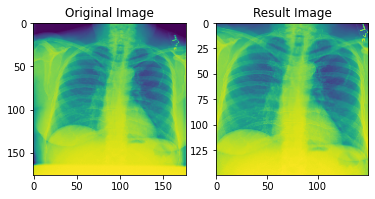

In [336]:
# test argumeatation functions
image, label = load_image_train(f'{base_dir}/images_sample/00000005_000.png', -1)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image / 255.)
ax[0].set_title("Original Image")

ax[1].imshow(random_crop(image) / 255.)
# ax[1].imshow(central_crop(image) / 255.)
# ax[1].imshow(random_jitter(image) / 255.)
# ax[1].imshow(normalize(image) / 255.)
ax[1].set_title("Result Image")
plt.show()

In [337]:
# Save image to each labels files

In [ ]:
for index, row in df.iterrows():
    img_idx = row['Image_Index']
    label = row['Finding_Labels']
    image = Image.open(f'{base_dir}/images_sample/{img_idx}')
    
    image_path = f'{base_dir}/{label}'
    if os.path.isdir(image_path) == False:
        print(f'Making image path: {image_path}')
        os.mkdir(image_path)
        
    
    image.save(f'{image_path}/{img_idx}')
print(f'saved all images')
    

In [26]:
# Data Pipeline

In [ ]:
for label,val in disease_labels.item():
    print(key)
    temp_ds = tf.data.Dataset.list_files(os.path.join(f'{base_dir}/{label}', '*.png'))
    temp_ds = temp_ds.map(lambda x: (x, val))
    if val == 0:
        train_ds = temp_ds
    else:
        train_ds = train_ds.concatenate(temp_ds)

In [ ]:
# # make multiple label to image
# def get_label(image_idx):
    
#     label_list = []
   
#     print(image_idx)
#     temp_label = [0]*len(disease_labels)

#     cur_label = df[df['Image Index']== image_idx]['Finding Labels'].item()
#     if cur_label == 'No Finding':
#         pass
#     else:    
#         if '|' in cur_label:
#             cur_labels = cur_label.split('|')
#             for cur_lb in cur_labels:
#                 temp_label[disease_labels[cur_lb]] = 1
#         else:
#             temp_label[disease_labels[cur_label]] = 1

#         image, label = load_image_train(f'/Users/seunghee/Downloads/images/images/{image_idx}', temp_label)

#         fig, ax = plt.subplots()
#         ax.imshow(image /255.)
#         ax.set_title(label)
#         plt.show()
        
# #     str_label = str(label)[1:-1]
# #     str_label = str_label.replace(',','-').replace(" ","")
# #     print(len(str_label))
#     return label
